In [62]:
import os, sys, re
import matplotlib.pyplot as plt
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.utils.model_handling import get_models_evaluation_data, load_checkpoint, get_model_cfg_from_checkpoint, get_training_cfg_from_checkpoint
from src.utils.visualization import plot_training_metrics
from src.utils.logs_handling import log_evaluated_model

In [ ]:
dir = 'models_architecture_A'

In [64]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '../'))
models = os.listdir(os.path.join(project_root, 'results', dir))

In [65]:
if dir == 'models_architecture_A':
    models = [
        'w41z1',
        '702zt',
        '7yo77',
        'n3w39',
        '694ih',
        '04z7z',
        'm608l',
        'l332j',
        'j0s91',
        '2n6j7',
        'q05o3',
    ]

Grouping model IDs based on hyperparameters being varied.

In [66]:
varying_lr = {}
varying_dropout = {}
varying_epoch = {}
varying_seq_len = {}

for model_id in models:
    chkpt = load_checkpoint(model_id, dir)
    cfg = get_model_cfg_from_checkpoint(chkpt)
    tcfg = get_training_cfg_from_checkpoint(chkpt)
    
    key = (tcfg.learning_rate, cfg.hidden_dropout_prob, tcfg.epochs)
    
    if tcfg.learning_rate not in varying_lr:
        varying_lr[tcfg.learning_rate] = [model_id]

    if cfg.hidden_dropout_prob not in varying_dropout:
        varying_dropout[cfg.hidden_dropout_prob] = [model_id]

    if tcfg.epochs not in varying_epoch:
        varying_epoch[tcfg.epochs] = [model_id]

    if cfg.training_seq_len not in varying_seq_len:
        varying_seq_len[cfg.training_seq_len] = [model_id]

In [67]:
def get_data(models):
    data = {}
    for model_id in models:
        data[model_id] = {}

        # get evaluation .pkl
        eval_data = get_models_evaluation_data(model_id=model_id, model_dir=dir)

        for env_info, eval_data in eval_data.items():
            env_seed = int(re.findall(r'\d+', env_info)[0])
            data[model_id][env_seed] = np.round(np.sum(eval_data), 2)

    return data

In [68]:
def average_reward_per_model(data, title, fig_name):
    models = list(data.keys())
    env_seeds = sorted(next(iter(data.values())).keys())

    # Compute statistics
    avg_rewards = []
    std_rewards = []
    std_percentage = []

    for model in models:
        rewards = [data[model][seed] for seed in env_seeds]
        mean_val = np.mean(rewards)
        std_val = np.std(rewards)
        avg_rewards.append(mean_val)
        std_rewards.append(std_val)
        std_percentage.append(abs((std_val / mean_val) * 100 if mean_val != 0 else 0))

    # Plot setup
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- First subplot: average reward with std ---
    axes[0].bar(models, avg_rewards, yerr=std_rewards, capsize=5, color='skyblue', edgecolor='black')
    axes[0].set_xlabel("Model ID")
    axes[0].set_ylabel("Average Reward")
    axes[0].set_title("Average Reward per Model (± Std)")
    axes[0].grid(axis='y', linestyle='--', alpha=0.5)

    # --- Second subplot: std as % of mean ---
    axes[1].bar(models, std_percentage, color='lightcoral', edgecolor='black')
    axes[1].set_xlabel("Model ID")
    axes[1].set_ylabel("Std as % of Mean")
    axes[1].set_title("Reward Variability (%)")
    axes[1].grid(axis='y', linestyle='--', alpha=0.5)

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(os.path.join(project_root, 'results', 'plots', fig_name))
    plt.show()

___
# Rewards per model (per env seed)

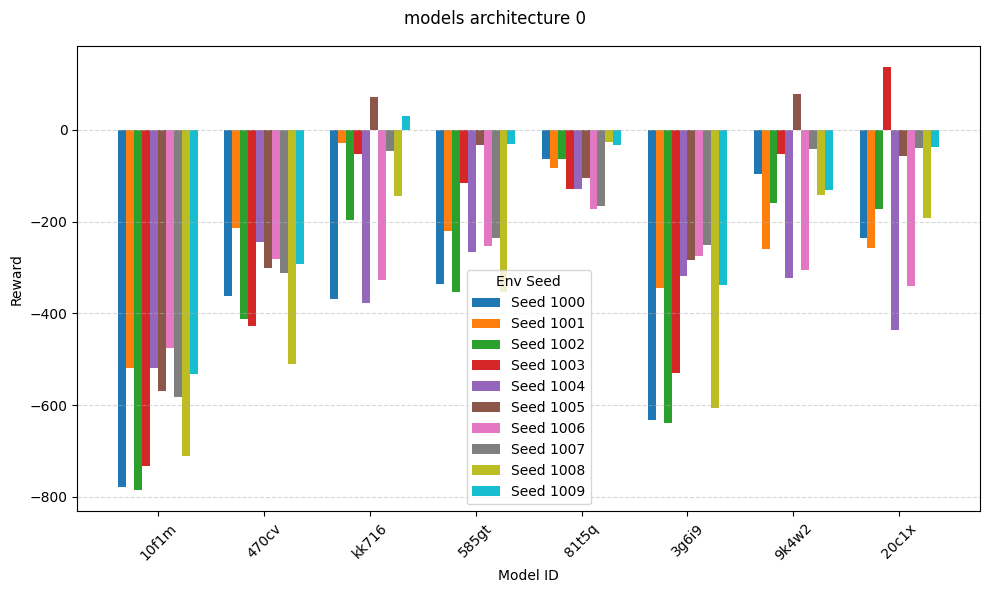

In [69]:
data = get_data(models)

# Extract keys
models = list(data.keys())
env_seeds = sorted(next(iter(data.values())).keys())  # e.g. [1000, 1001, 1002, 1003, 1004]

# Group bar plot setup
x = np.arange(len(models))
bar_width = 0.075
colors = plt.cm.tab10(np.linspace(0, 1, len(env_seeds)))

plt.figure(figsize=(10, 6))

# Plot one bar per env seed
for i, seed in enumerate(env_seeds):
    rewards = [data[m][seed] for m in models]
    plt.bar(x + i * bar_width, rewards, width=bar_width, label=f"Seed {seed}", color=colors[i])

# Formatting
plt.xticks(x + bar_width * (len(env_seeds) - 1) / 2, models, rotation=45)
plt.xlabel("Model ID")
plt.ylabel("Reward")
plt.legend(title="Env Seed")
plt.grid(axis='y', linestyle='--', alpha=0.5)

title = dir.replace('_', ' ')
plt.suptitle(title)
plt.tight_layout()
plt.savefig(os.path.join(project_root, 'results', 'plots', f'{dir}_models_rewards_per_env_seed.svg'))
plt.show()

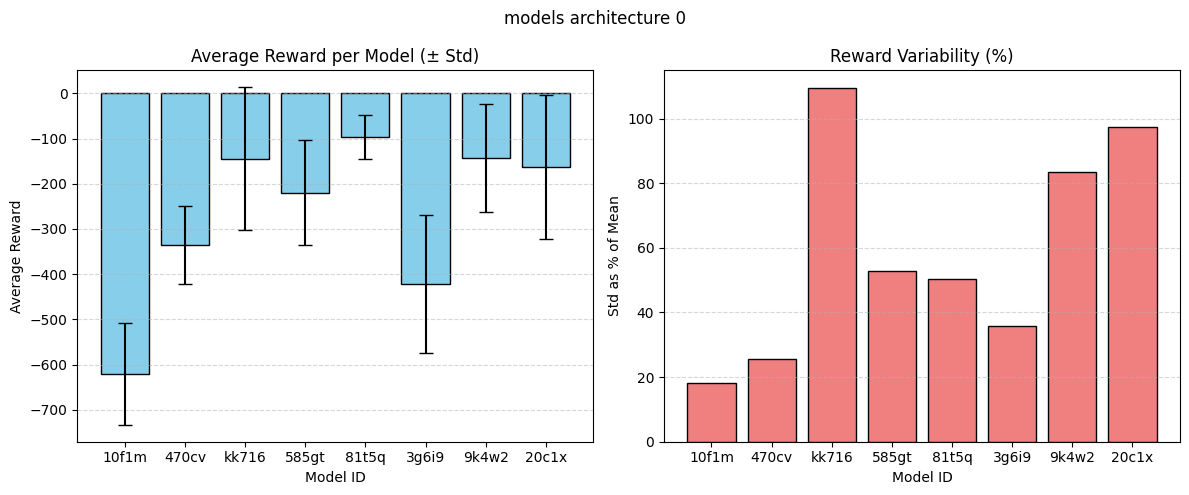

In [70]:
average_reward_per_model(get_data(models), dir.replace('_', ' '), f'{dir}_models_mean_std_reward.svg')

___
# Varying Dropout Probability

In [71]:
dropout_models = list(np.concatenate(list(varying_dropout.values())))
dropout_values = list(varying_dropout.keys())
title = dir.replace('_', ' ')
title = f'{title} (varying dropout)'
labels = [str(i) for i in dropout_values]

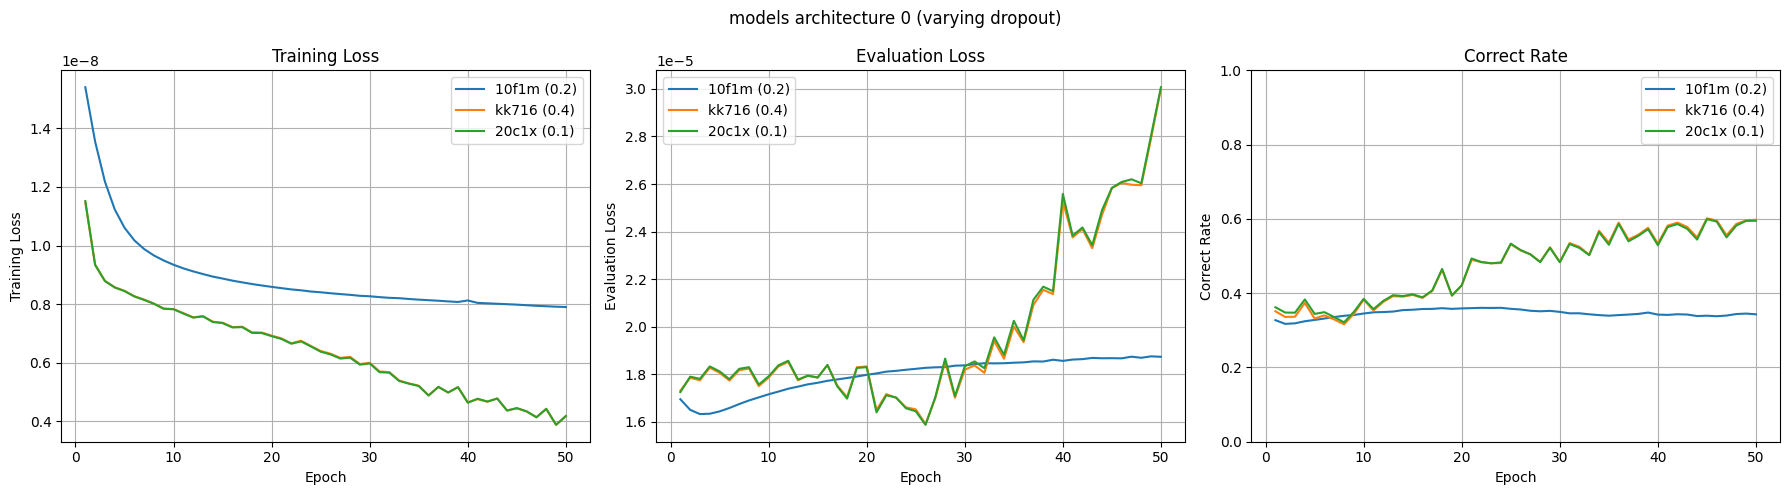

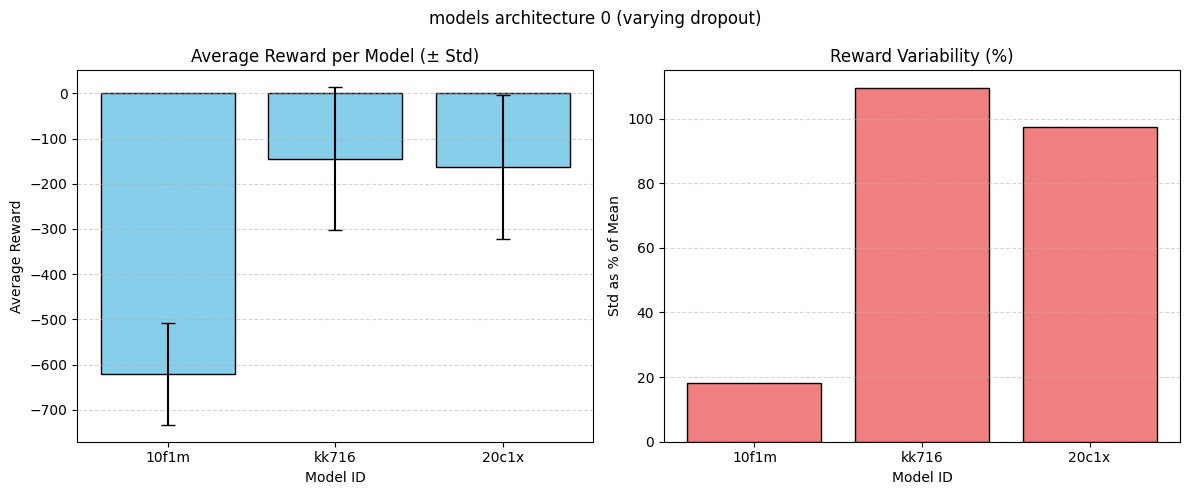

In [72]:
plot_training_metrics(model_id=dropout_models, title=title, model_dir=dir, label=labels, fig_name=f'{dir}_training_metrics-varying_dropout.svg')
average_reward_per_model(get_data(dropout_models), title, f'{dir}_varying_dropout_models_mean_std_reward.svg')

___
# Varying Learning Rate

In [73]:
lr_models = list(np.concatenate(list(varying_lr.values())))
lr_values = list(varying_lr.keys())
title = dir.replace('_', ' ')
title = f'{title} (varying lr)'
labels = [str(i) for i in lr_values]

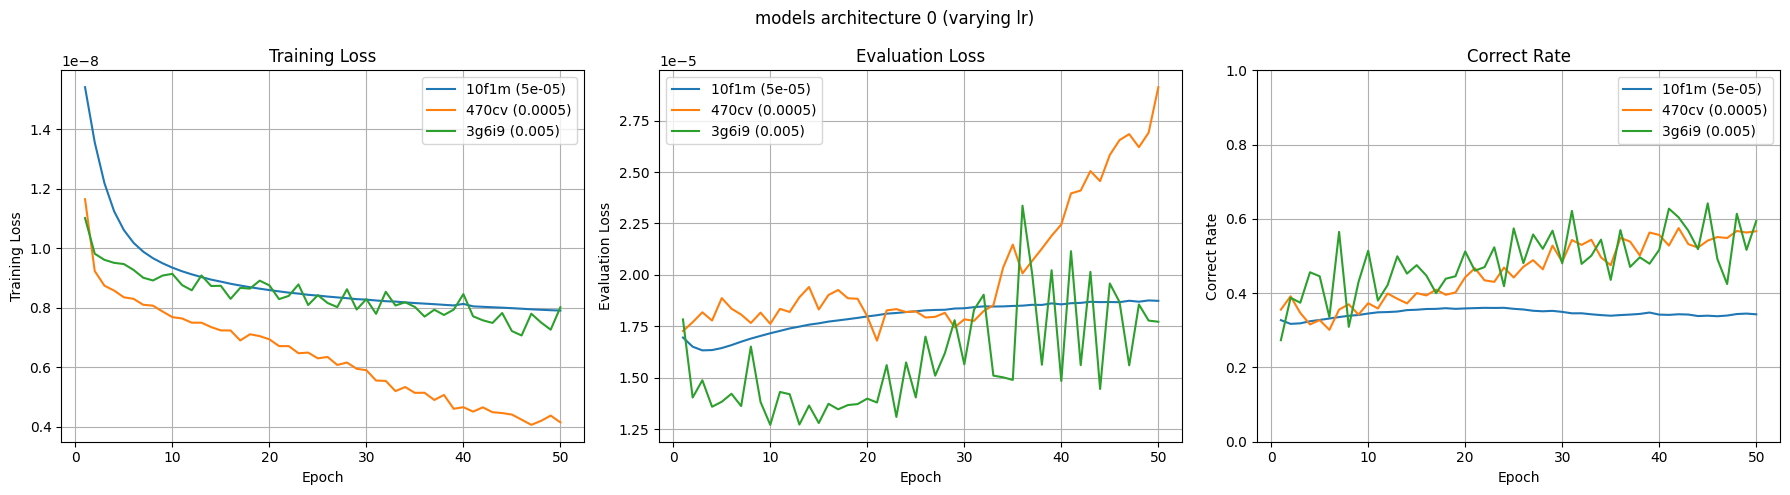

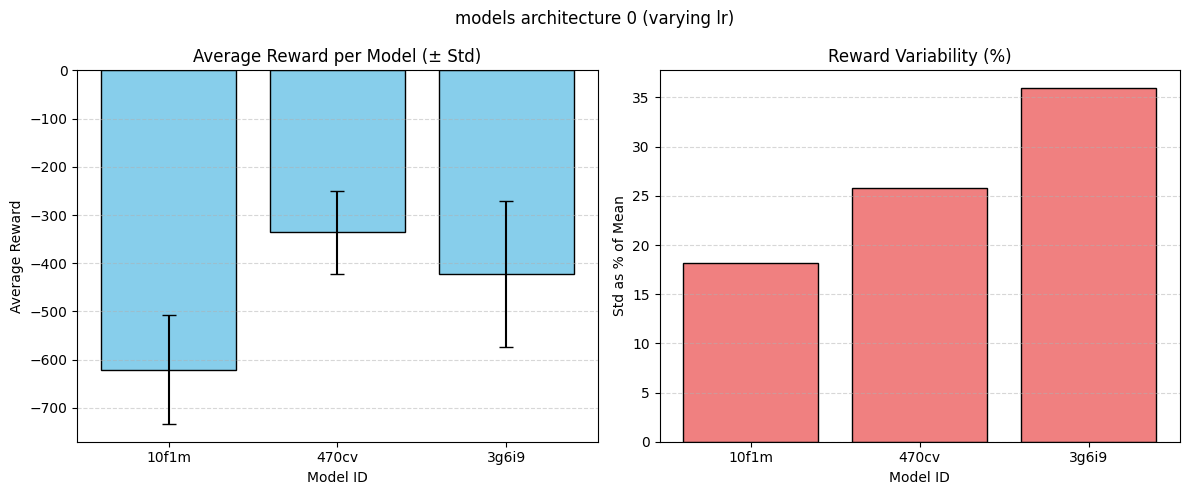

In [74]:
plot_training_metrics(model_id=lr_models, title=title, model_dir=dir, label=labels, fig_name=f'{dir}_training_metrics-varying_lr.svg')
average_reward_per_model(get_data(lr_models), title, f'{dir}_varying_lr_models_mean_std_reward.svg')

___
# Varying Sequence Length

In [75]:
seqlen_models = list(np.concatenate(list(varying_seq_len.values())))
seqlen_values = list(varying_seq_len.keys())
title = dir.replace('_', ' ')
title = f'{title} (varying seq. len.)'
labels = [str(i) for i in seqlen_values]

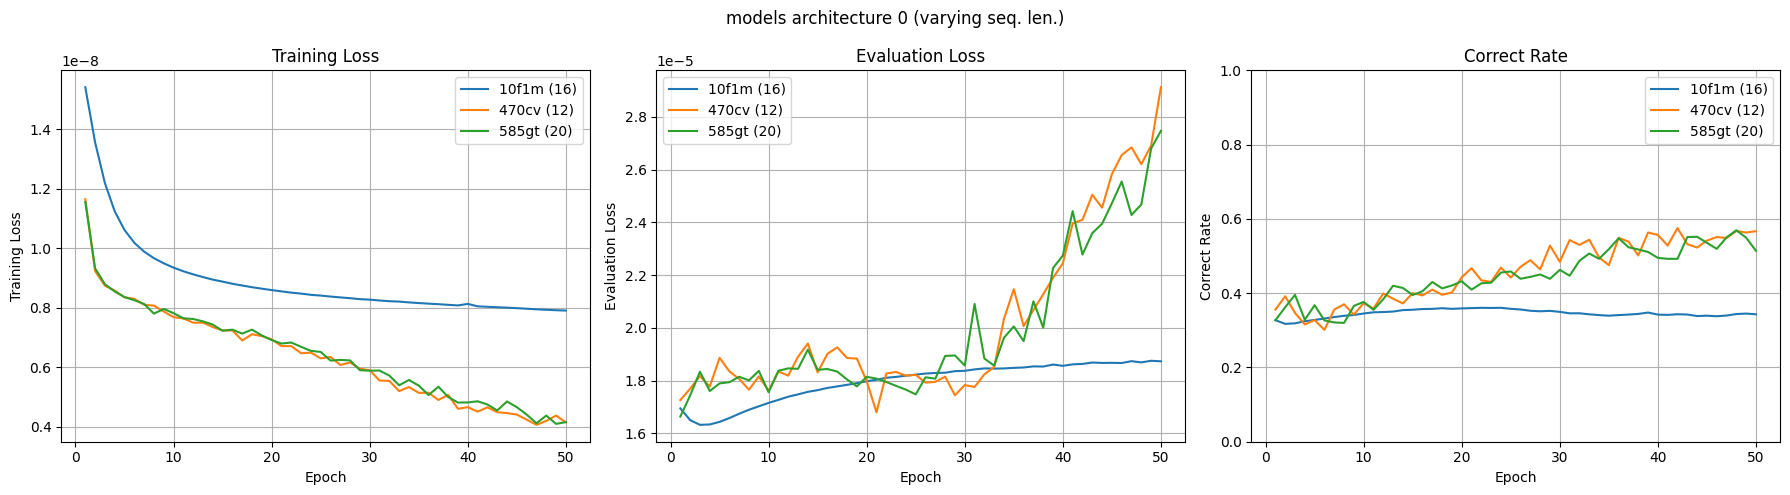

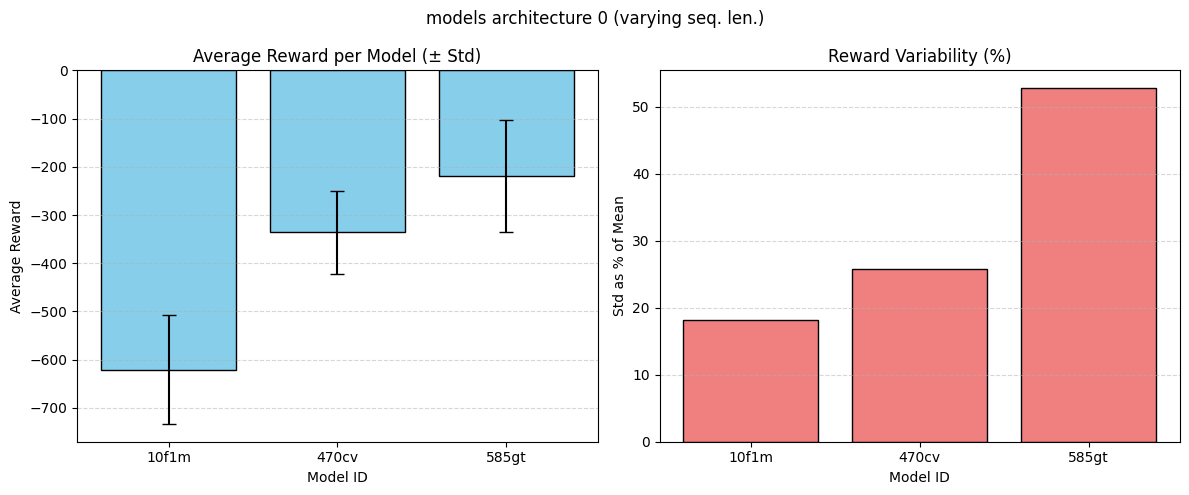

In [76]:
plot_training_metrics(model_id=seqlen_models, title=title, model_dir=dir, label=labels, fig_name=f'{dir}_training_metrics-varying_seq_len.svg')
average_reward_per_model(get_data(seqlen_models), title, f'{dir}_varying_seqlen_models_mean_std_reward.svg')

___
# Varying Epochs

In [77]:
epochs_models = list(np.concatenate(list(varying_epoch.values())))
epochs_values = list(varying_epoch.keys())
title = dir.replace('_', ' ')
title = f'{title} (varying epochs)'
labels = [str(i) for i in epochs_values]

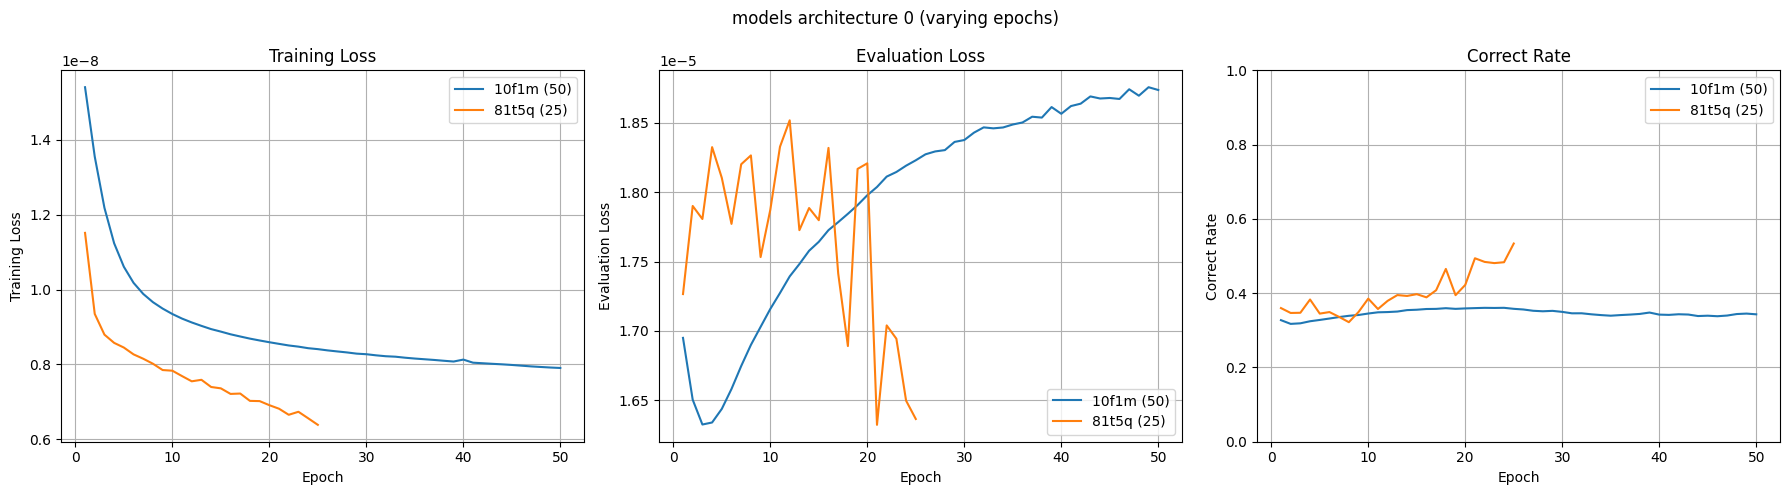

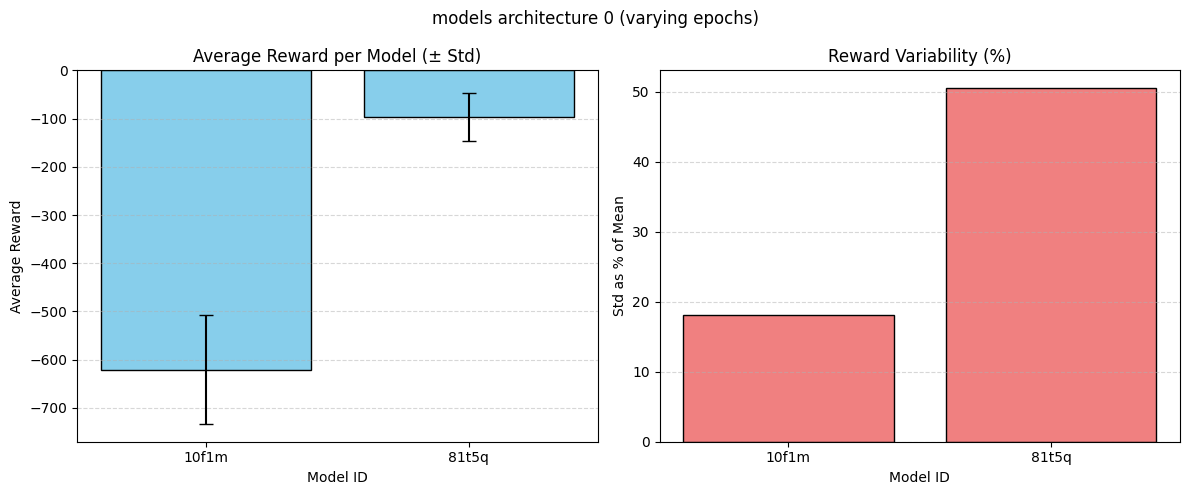

In [78]:
plot_training_metrics(model_id=epochs_models, title=title, model_dir=dir, label=labels, fig_name=f'{dir}_training_metrics-varying_epochs.svg')
average_reward_per_model(get_data(epochs_models), title, f'{dir}_varying_epoch_models_mean_std_reward.svg')

___
# Side-by-side Model Comparison

In [79]:
data = {}
for model_id in models:
    data[model_id] = {}

    # get evaluation .pkl
    eval_data = get_models_evaluation_data(model_id=model_id, model_dir=dir)

    for env_info, eval_data in eval_data.items():
        env_seed = int(re.findall(r'\d+', env_info)[0])
        data[model_id][env_seed] = np.round(np.sum(eval_data), 2)

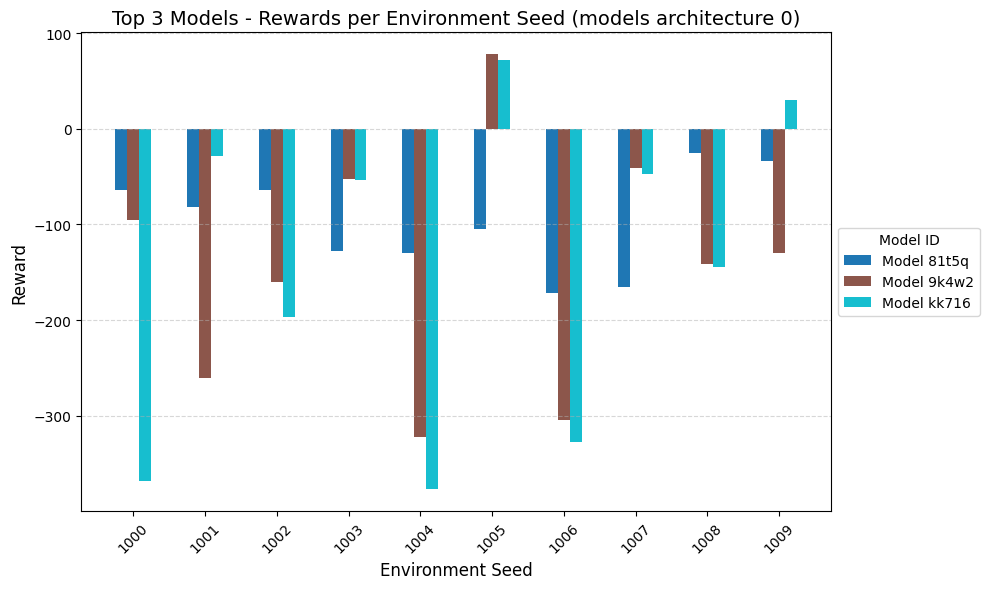

In [80]:
# Compute average reward per model
avg_rewards = {model: np.mean(list(env_rewards.values())) for model, env_rewards in data.items()}

# Get top 3 models by average reward
top_models = sorted(avg_rewards, key=avg_rewards.get, reverse=True)[:3]

# Extract keys
env_seeds = sorted(next(iter(data.values())).keys())  # e.g., [1000, 1001, 1002, 1003, 1004]

# Group bar plot setup
x = np.arange(len(env_seeds))  # now x-axis is env seeds
bar_width = 0.5 / len(top_models)  # width of each bar
colors = plt.cm.tab10(np.linspace(0, 1, len(top_models)))

plt.figure(figsize=(10, 6))

# Plot one bar per top model
for i, model in enumerate(top_models):
    rewards = [data[model][seed] for seed in env_seeds]
    plt.bar(x + i * bar_width, rewards, width=bar_width, label=f"Model {model}", color=colors[i])

title = dir.replace('_', ' ')
# Formatting
plt.xticks(x + bar_width * (len(top_models) - 1) / 2, env_seeds, rotation=45)
plt.xlabel("Environment Seed", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.title("Top 3 Models - Rewards per Environment Seed" + f' ({title})', fontsize=14)
plt.legend(
    title="Model ID",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig(os.path.join(project_root, 'results', 'plots', f'{dir}_top_3_models_reward_per_env.svg'))
plt.show()

Logging models to file.

In [83]:
for model_id in top_models:
    log_evaluated_model(model_id=model_id, model_dir_name=dir)